In [1]:
!nvidia-smi

Mon Oct  7 15:26:11 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.78       Driver Version: 410.78       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:03:00.0 Off |                  N/A |
|  0%   36C    P8    15W / 200W |    185MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   34C    P8    14W / 200W |    185MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [4]:
!numba --version

usage: numba [-h] [--annotate] [--dump-llvm] [--dump-optimized]
             [--dump-assembly] [--dump-cfg] [--dump-ast]
             [--annotate-html ANNOTATE_HTML] [-s]
             [filename]
numba: error: unrecognized arguments: --version


In [5]:
import numba

In [6]:
numba.__version__

'0.42.0'

In [3]:
# Necessary imports
%load_ext autoreload
%autoreload 2
import os
import sys
import logging

import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt

sys.path.append('..')
from seismiqb.batchflow import Dataset, Pipeline, FilesIndex
from seismiqb.batchflow import B, V, C, L, F, D, P, R, W
from seismiqb.batchflow.models.tf import DenseNetFC, TFModel
from seismiqb.batchflow.models.tf.layers import conv_block
from seismiqb import SeismicCropBatch, SeismicGeometry, SeismicCubeset, plot_loss
from seismiqb.batchflow import FilesIndex, Batch, action, inbatch_parallel
from seismiqb.batchflow.batch_image import transform_actions # pylint: disable=no-name-in-module,import-error
from seismiqb.src.utils import create_mask, aggregate, make_labels_dict, _get_horizons

from utils import *

from glob import glob
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: No module named 'numba.typed'

In [ ]:
%env CUDA_VISIBLE_DEVICES=0

## Load cube

In [ ]:
paths_cubes = ['/notebooks/SEISMIC_DATA/CUBE_3/P_cube.hdf5']

dsi = FilesIndex(path=paths_cubes, no_ext=True)
ds = SeismicCubeset(dsi)

In [ ]:
ds = ds.load()

## Load pretrained model

In [ ]:
train_pipeline = (Pipeline()
                     .load_model('dynamic', TFModel, 'extension', path='./weighted_dice_r_cube/') << ds)
train_pipeline.next_batch(1)
train_pipeline.get_model_by_name('extension')

In [ ]:
p_start_points = [1709, 1253, 527]

## Load initial label to start expansion procedure:

In [8]:
ds.labels[ds.indices[0]][(1709 + ds.geometries[ds.indices[0]].ilines_offset, ds.geometries[ds.indices[0]].xlines_offset)]

array([1160,  561,  904, 1182, 1182])

hey you


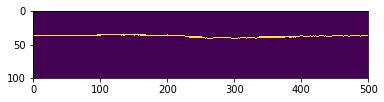

In [9]:
ds.subset_labels(p_start_points, crop_shape=[500, 500, 100], cube_index=0, show_prior_mask=True)

In [10]:
len(ds.prior_mask[ds.indices[0]])

250000

### Show current labels from above:

len  250000


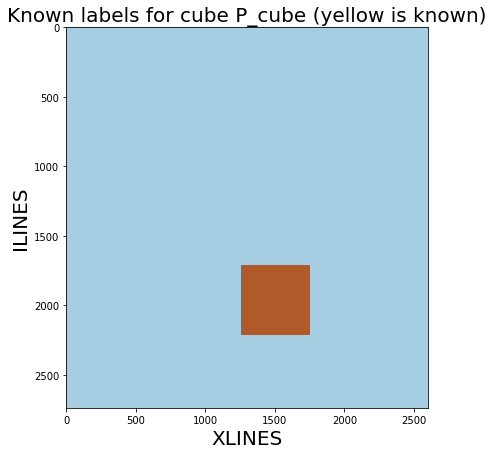

In [11]:
img = ds.show_labels(return_image=True, src='prior_mask')

In [12]:
from skimage.segmentation import find_boundaries

## Find borders

In [13]:
boundaries = find_boundaries(img).astype(np.int32)

In [14]:
np.unique(boundaries)

array([0, 1], dtype=int32)

In [15]:
border_coords = np.where(boundaries == 1)

In [16]:
np.min(border_coords[0])

1708

In [17]:
(border_coords[1][0])

1253

In [18]:
(border_coords[0][0])

1708

In [19]:
iline = 1710
x_min = 1254
x_max = 1300

In [20]:
# def make_border_grid(ds, idx, crop_shape, labels_img, stride=10):
#     borders_img = find_boundaries(img).astype(np.int32)
#     cube_name = ds.indices[idx]
#     il_len, x_len = labels_img.shape
#     border_coords = np.where(borders_img == 1)
#     il_min, il_max = np.min(border_coords[0]), np.max(border_coords[0])
#     x_min, x_max = np.min(border_coords[1]), np.max(border_coords[1])
#     il_offset = ds.geometries[ds.indices[idx]].ilines_offset
#     xl_offset = ds.geometries[ds.indices[idx]].xlines_offset

#     line_shape, height = crop_shape[1:]
#     iline_crops = []

#     # sample horizontal border points
#     for xline in range(x_min, x_max):
#         non_zero = np.where(borders_img[il_min:il_max, xline] == 1)[0]
#         _lower_il, _upper_il = np.min(non_zero) + il_min, np.max(non_zero) + il_min
#         _lower_h = ds.labels[cube_name][(_lower_il + il_offset, xline + xl_offset)] - height // 2
#         _upper_h = ds.labels[cube_name][(_upper_il + il_offset, xline + xl_offset)] - height // 2

#         _lower_il = _lower_il + stride - line_shape
#         _upper_il = _upper_il - stride
#         iline_crops.append([cube_name, _lower_il, xline, _lower_h])
#         iline_crops.append([cube_name, _upper_il, xline, _upper_h])
#     iline_crops = np.array(iline_crops, dtype=object)

#     xline_crops = []
#     # sample vertical border points
#     for iline in range(il_min, il_max):
#         non_zero = np.where(borders_img[iline, x_min:x_max] == 1)[0]
#         _lower_xl, _upper_xl = np.min(non_zero) + x_min, np.max(non_zero) + x_min
#         _lower_h = ds.labels[cube_name][(iline + il_offset, _lower_xl + xl_offset)] - height // 2
#         _upper_h = ds.labels[cube_name][(iline + il_offset, _upper_xl + xl_offset)] - height // 2

#         _lower_xl = _lower_xl + stride - line_shape
#         _upper_xl = _upper_xl - stride
#         xline_crops.append([cube_name, iline, _lower_xl, _lower_h])
#         xline_crops.append([cube_name, iline, _upper_xl, _upper_h])
#     xline_crops = np.array(xline_crops, dtype=object)
#     return iline_crops, xline_crops

# Create points generator crossing current border

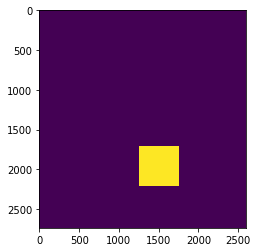

In [21]:
plt.imshow(img)

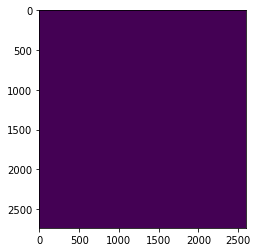

non zero xl 1252 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 2

In [77]:
ds = ds.make_expand_grid(ds.indices[0], crop_shape=(4, 100, 100),
                            labels_img=img, labels_idx=1)

print('Shape of ilines grid:', ds.iline_crops_info['grid_array'].shape)
print('Shape of xlines grid:', ds.xline_crops_info['grid_array'].shape)

In [65]:
%%time
for _ in range(ds.xline_crops_iters):
    print(ds.xline_crops_gen())
    print('---------------------')

[['P_cube' 1708 1163 514]
 ['P_cube' 1708 1742 514]
 ['P_cube' 1709 1162 514]
 ['P_cube' 1709 1742 514]
 ['P_cube' 1710 1162 514]
 ['P_cube' 1710 1742 514]
 ['P_cube' 1711 1162 514]
 ['P_cube' 1711 1742 514]
 ['P_cube' 1712 1162 514]
 ['P_cube' 1712 1742 514]
 ['P_cube' 1713 1162 514]
 ['P_cube' 1713 1742 514]
 ['P_cube' 1714 1162 514]
 ['P_cube' 1714 1742 514]
 ['P_cube' 1715 1162 514]
 ['P_cube' 1715 1742 514]]
---------------------
[['P_cube' 1716 1162 514]
 ['P_cube' 1716 1742 514]
 ['P_cube' 1717 1162 514]
 ['P_cube' 1717 1742 515]
 ['P_cube' 1718 1162 514]
 ['P_cube' 1718 1742 514]
 ['P_cube' 1719 1162 514]
 ['P_cube' 1719 1742 514]
 ['P_cube' 1720 1162 514]
 ['P_cube' 1720 1742 515]
 ['P_cube' 1721 1162 514]
 ['P_cube' 1721 1742 514]
 ['P_cube' 1722 1162 514]
 ['P_cube' 1722 1742 515]
 ['P_cube' 1723 1162 514]
 ['P_cube' 1723 1742 515]]
---------------------
[['P_cube' 1724 1162 514]
 ['P_cube' 1724 1742 515]
 ['P_cube' 1725 1162 515]
 ['P_cube' 1725 1742 515]
 ['P_cube' 1726 11

In [66]:
ds.xline_crops_info['predict_shape']

(600, 680, 114)

In [67]:
axes = (1, 0, 2)

In [68]:
model_pipeline = train_pipeline

In [69]:
CUBE_SHAPE = (ds.geometries[ds.indices[0]].ilines_len, ds.geometries[ds.indices[0]].xlines_len, ds.geometries[ds.indices[0]].depth)
CUBE_SHAPE

(2737, 2599, 2001)

In [88]:
def aggregate(array_crops, array_grid, crop_shape, predict_shape, order):
    """ Jit-accelerated function to glue together crops according to grid.
    At positions, where different crops overlap, only the maximum value is saved.
    This function is usually called inside SeismicCropBatch's method `assemble_crops`.
    """
    #pylint: disable=assignment-from-no-return
    total = len(array_grid)
    background = np.zeros(predict_shape)

    for i in range(total):
#         print('iii', i)
        if i > len(array_crops) - 1:
            print('endl')
            break
        il, xl, h = array_grid[i, :]
        il_end = min(background.shape[0], il+crop_shape[0])
        xl_end = min(background.shape[1], xl+crop_shape[1])
        h_end = min(background.shape[2], h+crop_shape[2])
        crop = np.transpose(array_crops[i], order)
        crop = crop[:(il_end-il), :(xl_end-xl), :(h_end-h)]
        previous = background[il:il_end, xl:xl_end, h:h_end]
        background[il:il_end, xl:xl_end, h:h_end] = np.maximum(crop, previous)
    return background

In [79]:
class TMPSeismicCropBatch(SeismicCropBatch):
    @action
    @inbatch_parallel(init='run_once')
    def assemble_crops(self, src, dst, grid_info, order=None):
        """ Glue crops together in accordance to the grid.

        Notes
        -----
        In order to use this action you must first call `make_grid` method of SeismicCubeset.
        Parameters
        ----------
        src : array-like
            Sequence of crops.
        dst : str
            Component of batch to put results in.
        grid_info : dict
            Dictionary with information about grid. Should be created by `make_grid` method.
        Returns
        -------
        SeismicCropBatch
            Batch with assembled subcube in desired component.
        """
        # Do nothing until there is a crop for every point
#         if len(src) != len(grid_info['grid_array']):
#             return self

        order = order or (2, 0, 1)
        # Since we know that cube is 3-d entity, we can get rid of
        # unneccessary dimensions
        src = np.array(src)
        src = src if len(src.shape) == 4 else np.squeeze(src, axis=-1)
        assembled = aggregate(src, grid_info['grid_array'], grid_info['crop_shape'],
                              grid_info['predict_shape'], order)
        setattr(self, dst, assembled)
        return self

In [80]:
ds.batch_class = TMPSeismicCropBatch

In [81]:
crop_shape=(100, 4, 100)

In [82]:
crop_shape=(4, 100, 100)

## Predict points from ds.xline_crops_iters

In [84]:
pred_pipeline_xline = (Pipeline()
                         .load_component(src=[D('geometries'), D('labels')],
                                         dst=['geometries', 'labels'])
                         .add_components('predicted_labels')
                         .crop(points=L(D('xline_crops_gen')),
                               shape=crop_shape, passdown='predicted_labels')
                         .load_component(src=[D('prior_mask')], dst=['predicted_labels'])
                         .load_cubes(dst='images')
                         .create_masks(dst='masks', width=1, n_horizons=1, src_labels='labels')
                         .create_masks(dst='cut_masks', width=1, n_horizons=1, src_labels='predicted_labels')
        #                  .apply_transform(np.transpose, axes=axes, src=['images', 'masks', 'cut_masks'])
                         .rotate_axes(src=['images', 'masks', 'cut_masks'])
                         .scale(mode='normalize', src='images')
                         .import_model('extension', model_pipeline)
                         .init_variable('result_preds', init_on_each_run=list())
                         .concat_components(src=('images', 'cut_masks'), dst='model_inputs')
                         .predict_model('extension', fetches='sigmoid',
                                          images=B('model_inputs'),
                                          cut_masks=B('cut_masks'),
                                          save_to=V('result_preds', mode='e'))) << ds

In [85]:
%%time
for i in range(ds.xline_crops_iters):
    if i % 10 == 0:
        print(i)
    pred_batch = pred_pipeline_xline.next_batch(1, n_epochs=None)

0
10
20
30
40
50
60
CPU times: user 12.9 s, sys: 43.8 s, total: 56.7 s
Wall time: 53.7 s


In [94]:
assemble_ppl = Pipeline().assemble_crops(src=pred_pipeline_xline.v("result_preds"), dst='assembled_pred_x', grid_info=ds.xline_crops_info, order=(2, 0, 1)) << ds
btch_xlines = assemble_ppl.next_batch(1)

## Predict points from ds.iline_crops_iters

In [33]:
crop_shape=(100, 4, 100)
axes = (1, 0, 2)

pred_pipeline_iline = (Pipeline()
                         .load_component(src=[D('geometries'), D('labels')],
                                         dst=['geometries', 'labels'])
                         .add_components('predicted_labels')
                         .crop(points=L(D('iline_crops_gen')),
                               shape=crop_shape, passdown='predicted_labels')
                         .load_component(src=[D('prior_mask')], dst=['predicted_labels'])
                         .load_cubes(dst='images')
                         .create_masks(dst='masks', width=1, n_horizons=1, src_labels='labels')
                         .create_masks(dst='cut_masks', width=1, n_horizons=1, src_labels='predicted_labels')
                         .apply_transform(np.transpose, axes=axes, src=['images', 'masks', 'cut_masks'])
                         .rotate_axes(src=['images', 'masks', 'cut_masks'])
                         .scale(mode='normalize', src='images')
                         .import_model('extension', model_pipeline)
                         .init_variable('result_preds', init_on_each_run=list())
                         .concat_components(src=('images', 'cut_masks'), dst='model_inputs')
                         .predict_model('extension', fetches='sigmoid',
                                          images=B('model_inputs'),
                                          cut_masks=B('cut_masks'),
                                          save_to=V('result_preds', mode='e'))) << ds

In [ ]:
%%time
for i in range(ds.iline_crops_iters):
    print(i)
    pred_batch = pred_pipeline_iline.next_batch(1, n_epochs=None)

In [91]:
assemble_ppl = Pipeline().assemble_crops(src=pred_pipeline_iline.v("result_preds"), dst='assembled_pred_iline', grid_info=ds.iline_crops_info, order=(0, 2, 1)) << ds
btch_ilines = assemble_ppl.next_batch(1)

In [191]:
ds.iline_crops_info.keys()

dict_keys(['cube_name', 'range', 'predict_shape', 'crop_shape', 'grid_array'])

In [36]:
ds.iline_crops_info['predict_shape']

(680, 504, 111)

In [51]:
(btch.assembled_pred_iline.shape)

(680, 504, 111)

In [55]:
points = ds.xline_crops_info['range'][0][0], ds.xline_crops_info['range'][1][0], ds.xline_crops_info['range'][2][0]
points

(1708, 1162, 508)

In [56]:
transforms = [lambda i_: ds.geometries[ds.indices[0]].ilines[i_ + points[0]],
              lambda x_: ds.geometries[ds.indices[0]].xlines[x_ + points[1]],
              lambda h_: h_ + points[2]]

In [57]:
from seismiqb.src.utils import _get_horizons, compare_horizons, dump_horizon, round_to_array, convert_to_numba_dict

# save ilines

In [101]:
ds.get_point_cloud(btch_ilines.assembled_pred_iline, threshold=0.001, dst='predicted_mask_iline',
                     coordinates=None, separate=True, transforms=transforms)

In [102]:
ds.predicted_mask_iline = {**ds.predicted_mask_iline[0], **ds.predicted_mask_iline[1]}

In [103]:
setattr(ds, 'predicted_mask_iline', {ds.indices[0]: convert_to_numba_dict(ds.predicted_mask_iline)})

# save xlines

In [113]:
ds.get_point_cloud(btch_xlines.assembled_pred_x, threshold=0.001, dst='predicted_mask_x',
                     coordinates=None, separate=True, transforms=transforms)

In [114]:
ds.predicted_mask_x = {**ds.predicted_mask_x[0], **ds.predicted_mask_x[1]}

In [115]:
setattr(ds, 'predicted_mask_x', {ds.indices[0]: convert_to_numba_dict(ds.predicted_mask_x)})

In [109]:
len(ds.predicted_mask_x[ds.indices[0]])

29441

In [239]:
15459 / 500

30.918

In [221]:
len(expanded_labels)

260956

In [222]:
len(ds.prior_mask[ds.indices[0]])

250000

In [223]:
setattr(ds, 'predicted_mask_x', {ds.indices[0]: convert_to_numba_dict(expanded_labels)})

In [224]:
len(ds.predicted_mask_x)

1

len  28365


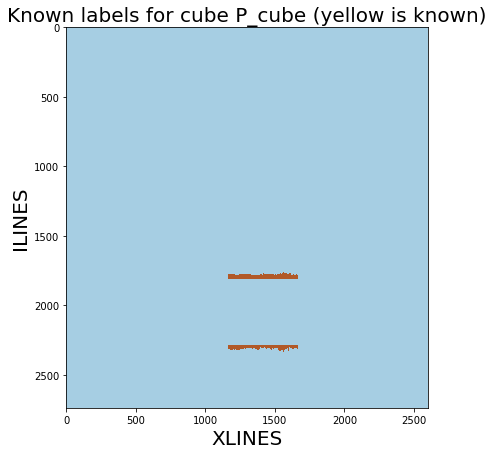

In [104]:
img_res = ds.show_labels(return_image=True, src='predicted_mask_iline')

len  29441


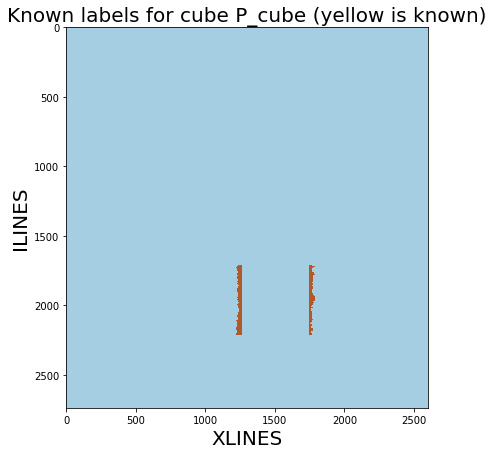

In [110]:
img_res = ds.show_labels(return_image=True, src='predicted_mask_x')

In [116]:
expanded_labels = {**ds.predicted_mask_x[ds.indices[0]], **ds.predicted_mask_iline[ds.indices[0]], **ds.prior_mask[ds.indices[0]]}

In [117]:
setattr(ds, 'prior_mask', {ds.indices[0]: convert_to_numba_dict(expanded_labels)})

In [1]:
img = ds.show_labels(return_image=True, src='prior_mask')

NameError: name 'ds' is not defined